# Star Type Classification

Classifying the star type of an unclassifed star using its absolute temperature and absolute magnitude

# Part I: Introduction

There are many different types of stars that exist in our universe, and they can be classified into different categories. Grouping stars of similar characteristics allows individuals from astronomers to the general public to glean the general characteristics of a star, such as age, magnitude, or origin, simply by knowing its "star type." For our project we will consider two specific characteristics of stars, use them to classify the star type of an unclassified star, and determine how accurately these two characteristics can be used to predict star type. A high accuracy would indicate that these characteristics have unique ranges corresponding to different star types, thus they can be used as indications of star type.

To obtain data on stars, we will be using the “Star dataset to predict star types” dataset from Kaggle, which consists of data for 240 observations (240 stars). The characteristics, or variables, recorded are indicated along with the units of measurement as follows:
- Absolute Temperature (Kelvin)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
    {note: Mv= m - 2.5log[(d/10)^2]}
- Star color (white, red, blue, etc.)
- Spectral class (O, B, A etc.)

The 6 different star types considered in this data set are given a generic numerical value for ease of use in classification and are as follows:
- Brown Dwarf (star type = 0)
- Red Dwarf (star type = 1)
- White Dwarf (star type = 2)
- Main sequence (star type = 3)
- Supergiant (star type = 4)
- Hypergiant (star type = 5)

For the purpose of our classification, we will only be using **Absolute Temperature (K)** and **Absolute Magnitude (Mv)** to predict the **Star Type** of an unclassified star, guided by the question: “can we create a classifier that can accurately classify the Star Type of an unclassified star?” All other variables will be removed from the data set before we begin our classification.

In [1]:
# add why we chose these two variables

# Part II: Preliminary exploratory data analysis

To begin, we created a Jupyter Notebook and attached all of the packages that we would need for our classification. We also set a random seed so we would not risk forgetting it later.

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)
library(shiny)

set.seed(777)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Next, we loaded the dataset from Kaggle into our notebook. The original column names had spaces, so we changed the names into a more usable format. Additionally, the star type column was of the wrong data type so we converted it into data type "factor". Finally, we selected only the columns that we are interested in for our classification (absolute temperature, absolute magnitude, and star type). The data is now in a tidy format and ready for use in classifcation.

To give a sense of how the data looks now, we have shown the first 6 and last 6 rows.
    
{note: the dataset has 240 observations, so there are 240 rows. Additionally, the data is currently organised in order of increasing star type (0-6).}

In [4]:
raw_data <- read_csv("https://raw.githubusercontent.com/uchou92/dcsi-100-2023w1-group-28/main/6_class_csv%5B1%5D.csv", col_names=FALSE,
             skip=1)

colnames(raw_data) <- c("abs_temperature", "luminosity", "radius", "abs_magnitude", "star_type", "star_color", "spectral_class")

star_data <- raw_data|>
        mutate(star_type = as_factor(star_type))|>
        mutate(star_type = fct_recode(star_type, "star_type" = "star_type"))|>
        select(abs_magnitude, star_type, abs_temperature)

h3("Table. 1: First 6 rows of wrangled data set")
    head(star_data) 
h3("Table. 2: Last 6 rows of wrangled data set")
tail(star_data)

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): X6, X7
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `star_type = fct_recode(star_type, star_type = "star_type")`.
Caused by warning:
! Unknown levels in `f`: star_type”


Shiny tags cannot be represented in plain text (need html)

abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
16.12,0,3068
16.60,0,3042
18.70,0,2600
16.65,0,2800
20.06,0,1939
16.98,0,2840


Shiny tags cannot be represented in plain text (need html)

abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
-7.67,5,21904
-9.93,5,38940
-10.63,5,30839
-10.73,5,8829
-11.23,5,9235
-7.80,5,37882


We can also see how absolute temperature and absolute magnitude are related with respect to star type. Already it is possible to see that the different star types are grouped in different regions on the plot, indicating that we should have some success with our classifier. For example, all observations of star type 0 (Brown Dwarf) are found at high values of absolute magnitude and low values of absolute temperature, while star type 5 (Hypergiant) is the only star type found at very low absolute magnitudes.

{note: this data is unstandardized and axes not to scale}

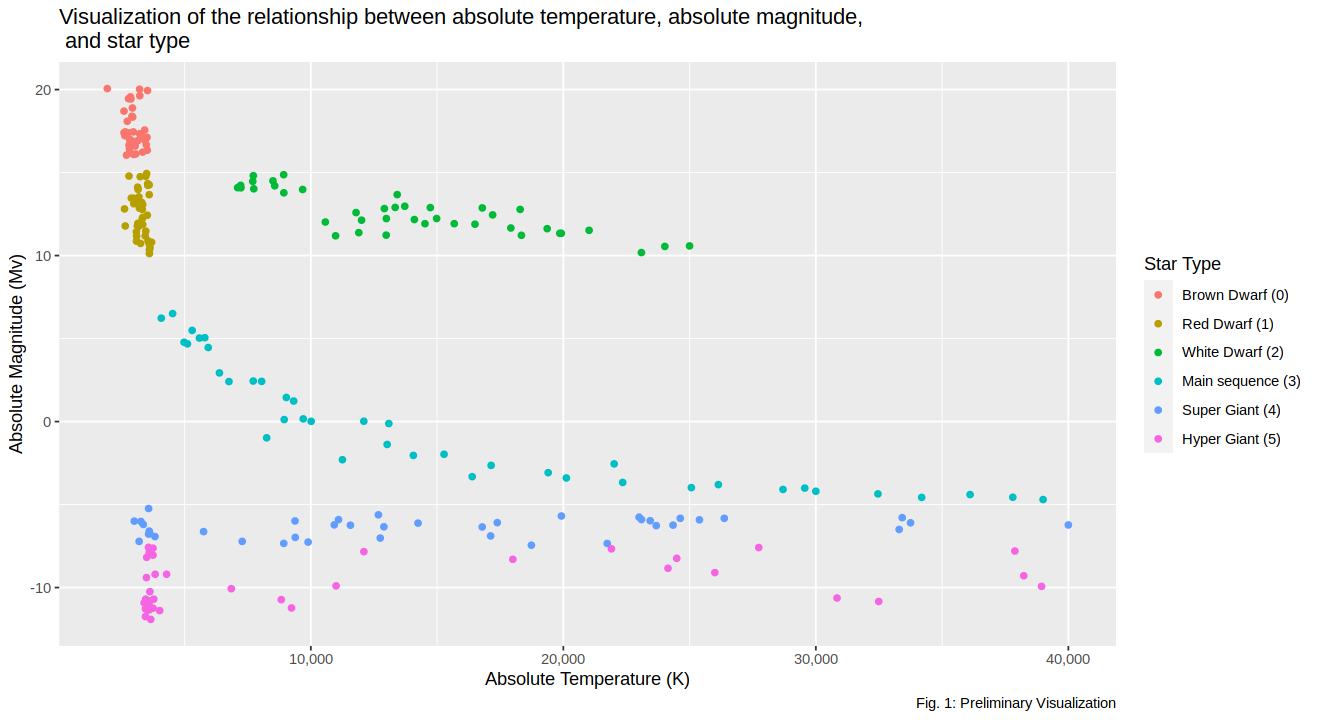

In [32]:
summary_plot <- star_data |>
    ggplot(aes(x = abs_temperature, y = abs_magnitude, color = star_type))+
            geom_point()+
            scale_color_hue(labels = c("Brown Dwarf (0)", "Red Dwarf (1)", "White Dwarf (2)","Main sequence (3)", 
                                       "Super Giant (4)", "Hyper Giant (5)")) +
            labs(x = "Absolute Temperature (K)", y = "Absolute Magnitude (Mv)", color = "Star Type") +
            ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude, \n and star type") +
            scale_x_continuous(labels = scales::comma_format())+
            labs(caption = "Fig. 1: Preliminary Visualization")
summary_plot

options(repr.plot.width = 11, repr.plot.height = 6)

The first step to beginning our classification is to separate our data into a training set and a testing set. We used a 75% training-testing split, and stratified by star type so as to avoid class imbalance in either the testing or training data sets.

In [7]:
data_split <- star_data |>
            initial_split(prop = 0.75, strata = star_type)

data_training <- training(data_split)
data_testing <- testing(data_split)

To give an overview of what our training set looks like now that it is ready for use in classification, we have summarised how many of each star type is present in the training set. Since we know there were 240 original observations, we should have 75% so 30 observations of each star type in our training set. If we don't, then we know we have some missing data.

{note: there is no missing data!}

In [8]:
summary_training <- data_training |>
                    group_by(star_type) |>
                    summarize(count = n()) |>
                    arrange(desc(count))
h3("Table. 3: Distribution of star type in training set")
summary_training

Shiny tags cannot be represented in plain text (need html)

star_type,count
<fct>,<int>
0,30
1,30
2,30
3,30
4,30
5,30


# Part III: Classification

We will be performing classification using the K-nearest neighbours algorithm to classify star type using absolute temperature and absolute magnitude. First, we will tune for K so we know how many neighbours to consider. 

## Tuning for K

To begin tuning, we created a recipe with the training data. Since our data only contains our two predictor variables (absolute temperature and absolute magnitude) and our response variable (star type), we can simply set our recipe to predict star type using all variables (denoted '~.'). We want to standardize both predictor variables by scaling and centering about a mean of 0 and standard deviation of 1, so as to ensure all data is on a comparable scale and contributes equally to K-nearest distance calculations performed by the algorithm.

In [9]:
star_recipe <- recipe(star_type ~., data_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

To determine the best value for K, we need to perform cross-validation, essentially splitting the training data into a new training and testing set and testing for different K-values to determine the value with the highest accuracy. We will use 5-fold cross validation and stratify by star type again.

In [10]:
star_vfold <- vfold_cv(data_training, v = 5, strata = star_type)

We have chosen to test K-values ranging from 1 to 10, because this is the most commonly suitable range.

In [39]:
kvals <- tibble(neighbors = seq(from = 1, to = 10))

In order to tune the algorithm, we pass the 'tune()' argument to the nearest_neighbor function and give the specifications. We will use the 'kknn' engine, classification mode, and weigh_func = "rectangular" so that the algorithm uses the straight line distance between observations when determine nearest neighbours.

In [40]:
star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Finally, we combine everything into a workflow and can test the different K-values.

In [41]:
star_workflow <- workflow() |>
                    add_recipe(star_recipe) |>
                    add_model(star_spec) |>
                    tune_grid(resamples = star_vfold, grid = kvals)

Now, we can collect our results and see which K-value had the highest accuracy. To better visualize the varying degrees of accuracy, we also plotted a graph of K-value (on the x-axis) vs. accuracy (on the y-axis).

Shiny tags cannot be represented in plain text (need html)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9500000,5,0.016197089,Preprocessor1_Model01
2,accuracy,multiclass,0.9500000,5,0.016197089,Preprocessor1_Model02
3,accuracy,multiclass,0.9277778,5,0.014163943,Preprocessor1_Model03
4,accuracy,multiclass,0.9111111,5,0.022222222,Preprocessor1_Model04
5,accuracy,multiclass,0.8666667,5,0.010393493,Preprocessor1_Model05
6,accuracy,multiclass,0.8722222,5,0.006804138,Preprocessor1_Model06
7,accuracy,multiclass,0.8500000,5,0.006804138,Preprocessor1_Model07
8,accuracy,multiclass,0.8500000,5,0.006804138,Preprocessor1_Model08
9,accuracy,multiclass,0.8555556,5,0.013608276,Preprocessor1_Model09


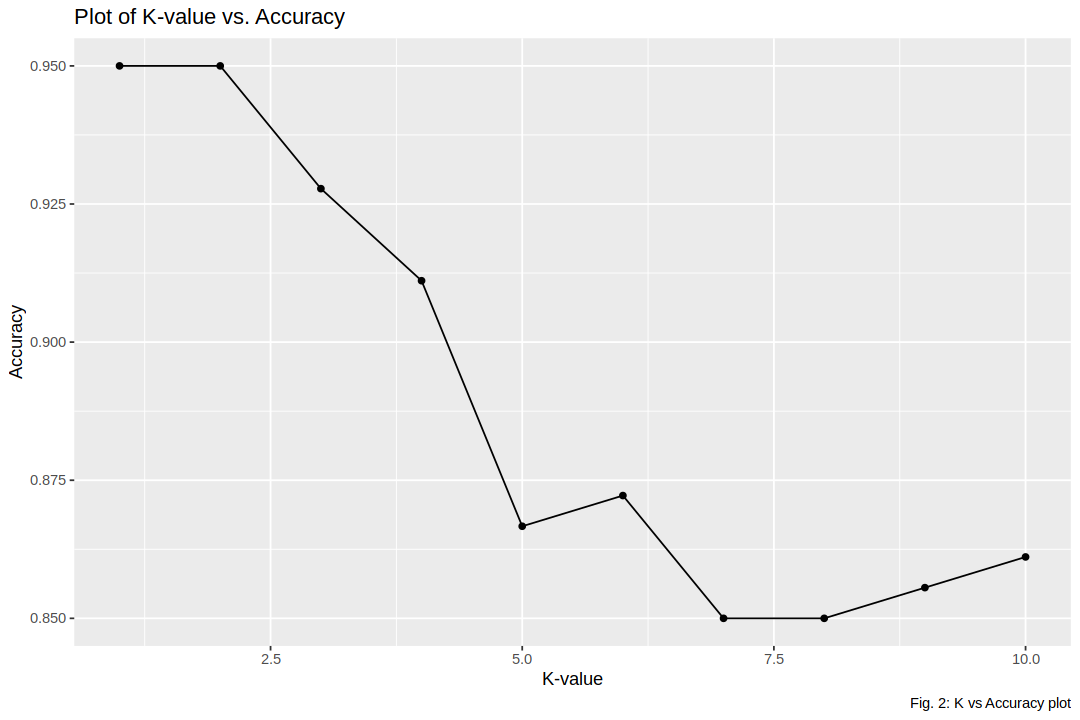

In [43]:
star_results <- star_workflow |> 
                    collect_metrics() |>
                    filter(.metric == "accuracy")
h3("Table. 4: Results of tuning")
star_results

star_plot <- star_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K-value", y = "Accuracy")+
                ggtitle("Plot of K-value vs. Accuracy")+
                labs(caption = "Fig. 2: K vs Accuracy plot")
star_plot

options(repr.plot.width = 8, repr.plot.height = 6)

As you can see from both the table and the graph, the accuracy for K = 1 and K = 2 is the same at 95% and is the highest degree of accuracy. We have chosen to use K = 2 to avoid over-fitting our data, since our training set may not completely reflect the whole data set.

In [15]:
#add explanation of why K=2 above

## Measuring the accuracy of our classifier

Another, more quantitative, method of measuring the accuracy of our classifier is by analysing its accuracy with the testing set. Since we tuned the classifier using the training set, we can use the classifier to predict all of the star types of the observations in the testing set, then compare the prediction with the true value and see how our classifier did.

First, we recreate the specifications for the algorithm with our chosen K-value of 2. Then, we combine this new specification with the recipe we created earlier and fit it to the training data.

In [16]:
star_main_spec <- nearest_neighbor(weight_func = "rectangular", n = 2 ) |>
                set_engine("kknn") |> 
                set_mode("classification")

star_fit <- workflow() |>
            add_recipe(star_recipe) |> 
            add_model(star_main_spec) |>
            fit(data_training)

Next, we use the algorithm to predict the star types of the testing set. We use the bind_cols function to add the predicted class directly to our data set so we can easily compare the predicted and actual class. The first 6 predictions are shown for reference.

In [17]:
star_predictions <- star_fit |>
                     predict(data_testing) |>
                     bind_cols(data_testing)
h3("Table. 5: First 6 predictions of testing set")
head(star_predictions)

Shiny tags cannot be represented in plain text (need html)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
0,18.70,0,2600
1,10.48,1,3628
2,11.89,2,16500
2,14.20,2,8570
2,14.47,2,7700
2,14.08,2,7230


So far, it looks like our classifier has perfect accuracy. To easily see how the classifier does for all observations in the testing set without looking through 60 rows of data, we can compute the confusion matrix which tells us how many predictions were made for each star type and how it compares with the 'truth' - the actual star type.

{note: since the testing set was 25% of the original 240 observations, it contains 60 observations: 10 of each star type}

In [18]:
star_matrix <- conf_mat(star_predictions, truth = star_type, estimate = .pred_class)
h3("Table. 6: Confusion matrix")
star_matrix

Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction  0  1  2  3  4  5
         0 10  0  0  0  0  0
         1  0 10  0  0  0  0
         2  0  0 10  0  0  0
         3  0  0  0  8  0  0
         4  0  0  0  2  9  0
         5  0  0  0  0  1 10

From the confusion matrix, it seems our classifier only made 3 mistakes: twice, the classifier predicted a star was of star type 4 (Supergiant) when it was actually when it was actually star type 3 (Main Sequence), and predicted one star was of star type 5 (Hypergiant) when it was actually of star type 4 (Supergiant). 3 mistakes out of 60 predictions is pretty accurate! We can also compute the accuracy using the metrics function and filtering for accuracy:

In [20]:
star_metrics <- star_predictions |>
                metrics(truth = star_type, estimate = .pred_class) |>
                filter(.metric == "accuracy")
h3("Table. 7: Accuracy of classifier")
star_metrics

Shiny tags cannot be represented in plain text (need html)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.95


Our classifier is then 95% accurate! We can also revisit the plot of absolute temperature vs. absolute magnitude to try and see where our classifier struggled. First we need to determine the absolute magnitude and absolute temperature of these 3 stars:

In [21]:
star_mistakes1 <- star_predictions |>
                filter(star_type == "3", .pred_class == "4")
h3("Table. 8: Falsely predicted class 4")
star_mistakes1

star_mistakes2 <- star_predictions |>
                filter(star_type == "4", .pred_class == "5")
h3("Table. 9: Falsely predicted class 5")
star_mistakes2

Shiny tags cannot be represented in plain text (need html)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
4,-3.32,3,16390
4,-4.57,3,34190


Shiny tags cannot be represented in plain text (need html)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
5,-7.346,4,21738


In [22]:
mistake_star_1 <- c(16390, -3.32)

mistake_star_2 <- c(34190, -4.57)

mistake_star_3 <- c(21738, -7.346)

Now we can annotate the graph to see just where it exactly these stars lie relative to the others. The predicted star type is indicated by the corresponding number, the actual star type is indicated by the colour of the point.

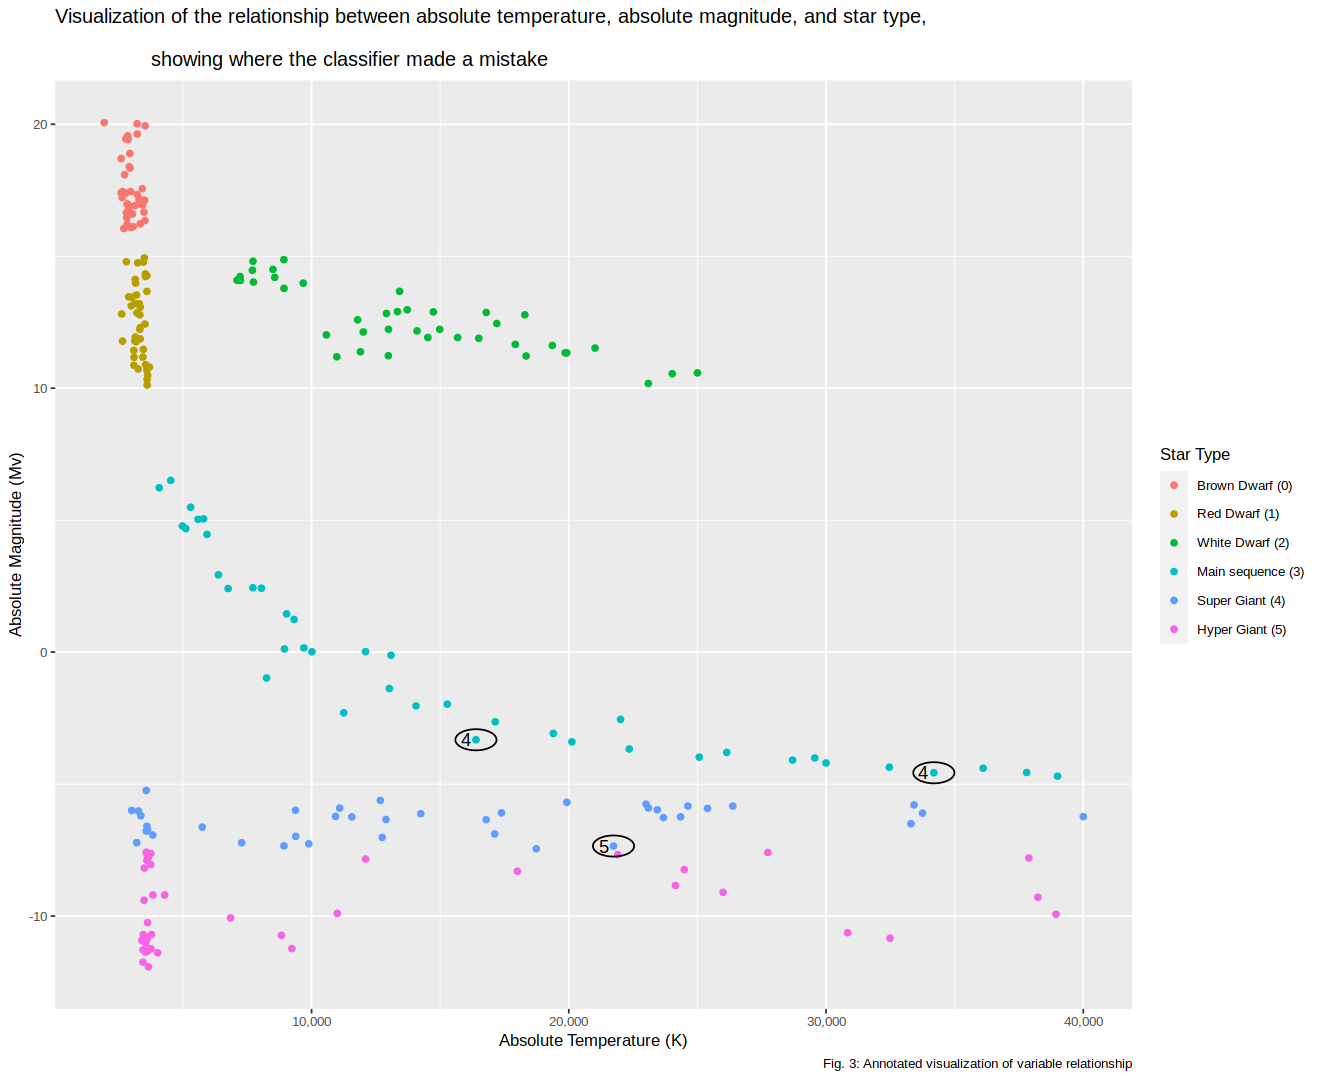

In [47]:
mistakes_plot <- summary_plot +
        annotate("path", 
                 x = mistake_star_1[1] + 800*cos(seq(0,2*pi,length.out=1000)),
                 y = mistake_star_1[2] + 0.4*sin(seq(0,2*pi,length.out=1000))) +
        annotate("text", x = 16000, y =  -3.32, label = "4") +
        theme(text = element_text(size = 10))+
            annotate("path", 
                 x = mistake_star_2[1] + 800*cos(seq(0,2*pi,length.out=1000)),
                 y = mistake_star_2[2] + 0.4*sin(seq(0,2*pi,length.out=1000))) +
        annotate("text", x = 33750, y =  -4.57, label = "4") +
        theme(text = element_text(size = 10))+
        annotate("path", 
                 x = mistake_star_3[1] + 800*cos(seq(0,2*pi,length.out=1000)),
                 y = mistake_star_3[2] + 0.4*sin(seq(0,2*pi,length.out=1000))) +
        annotate("text", x = 21350, y =  -7.346, label = "5") +
        theme(text = element_text(size = 10))+
        ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude, and star type, \n 
                showing where the classifier made a mistake") +
        labs(caption = "Fig. 3: Annotated visualization of variable relationship")
mistakes_plot

options(repr.plot.width = 11, repr.plot.height = 9)

If we consider that this data is unscaled, we know that vertical distances will be at least a factor of 10 smaller, since absolute temperature is measured in tens of thousands. Therefore, it is possibly to see from the plot that these observations are plotted very close stars of another type: the type it was mistakenly assigned. It is easy to understand then how the classifier made an error!

## Classifying an unlabelled star using our model

One way we can apply our classifier is to predict the star type of a star not included in the Kaggle dataset. Alpha Canis Majoris, commonly known as the star Sirius, lies in the Canis Major constellation and as the brightest star it is one of the more identifiable and well known stars in the night sky. Its companion, Sirius B, has an absolute magnitude of 11.3Mv and an absolute temperature of 25000K. 

In [24]:
siriusB <- tibble(abs_magnitude = 11.3, abs_temperature = 25000)

h3("Table. 10: Characteristics of Sirius")
siriusB

Shiny tags cannot be represented in plain text (need html)

abs_magnitude,abs_temperature
<dbl>,<dbl>
11.3,25000


We know that the star type of Sirius B is White Dwarf, corresponding to star type 2. We can use our classifier to predict the star type of Sirius B and see if it matches.

In [25]:
siriusB_prediction <-predict(star_fit, siriusB)

h3("Table. 11: Predicted star type of Sirius")
siriusB_prediction

Shiny tags cannot be represented in plain text (need html)

.pred_class
<fct>
2


Our classifier has predicted Sirius B to be of star type 2, which does in fact correspond to White Dwarf!

# Part IV: Discussion

In [1]:
#so this is just significance, etc.
#also add what the errors in classification could mean, i.e. what are the differences between the star type 4 and 5 etc and what would a 
    #wrong classification mean
# add info on how choosing k =2 was best and what would've happened if we chose k =1 
# potential question arising: could the distinction parameters between star types change as more are discovered / scientific discoveries made?
    # could star type 3 for example be split into two different groups since it is so spread out?
#data might be over-fit, coiuld in future train wiht more observations
# since the star types are clustered, we could re-do combining clustering and classification
#- We are expecting to successfully find the star type (6 classes ranging from 0-5) based on Temperature (K) and Absolute Magnitude(Mv) of a single unclassified point. 

# These findings could impact users who are not familiar with stars to easily identify those star types based on these characteristics. 
# Some future questions that this could lead to are what other variables can impact the classification of star types apart from absolute temperature and magnitude? 
# Are there any exceptions to the identification of Star types that can occur due to these other variables? 
# How can classification help us in the Astronomy in the real-world workplace such as NASA?

Throughout the classification process, we successfully determined the star type using Absolute Temperature (K) and Absolute Magnitude (Mv). We began by tuning the parameter for K, exploring the number of neighbors to consider in order to ascertain the star type of a given data point. According to our analysis, setting k=2 implies considering the two nearest neighbors when making predictions. Subsequently, the majority class among these two neighbors is assigned as the predicted class for the data point. Achieving a 95% accuracy with this model supported our hypothesis, demonstrating our ability to create a classifier that accurately identifies the Star Type of an unclassified star.

The classification of a single unclassified point is illustrated in Table 10 and Table 11. However, we encountered minor classification errors, as depicted in Figure 3. These errors were anticipated since, in Figure 3, the points are relatively close to other star types. Therefore, with k=2, a certain level of error is expected, as reflected in the 95% accuracy. Examining the accuracy plot for different k-values in Figure 2, we observed that k=1 provides the same accuracy as k=2. Nevertheless, opting for k=2 is preferred because k=1 is more susceptible to outliers, where a single outlier or mislabeled point in the training set could significantly impact predictions.

Looking ahead, these findings can be beneficial for users unfamiliar with stars, enabling them to easily identify star types based on specific characteristics. For example, Figure 3 visually distinguishes each star type on the plot, aiding individuals studying stars in swiftly identifying unknown stars without manual comparisons on a table.

Upon reviewing the final results, several future questions arise. What other variables, apart from absolute temperature and magnitude, can impact the classification of star types? Are there exceptions to the identification of star types due to these additional variables? Furthermore, how can classification contribute to real-world applications in Astronomy, such as those within organizations like NASA? These questions emerged from our observation of numerous variables in the original dataset contributing to star type characteristics. Consequently, we aim to explore whether other characteristics can achieve similar classification efficacy as absolute temperature and magnitude. Additionally, we are interested in assessing whether this classification can enhance efficiency and reduce the time required for identifying unknown stars across the universe for those working in Astronomy.

# Part V: References

In [27]:
# find info on how star types are decided and add to intro as well